# Exploratory Data Analysis

This notebook should be used to analyze time series and prepare the dataset.

In [ ]:
!pip install pandas google-cloud-bigquery pandas-gbq statsmodels matplotlib

In [1]:
import pandas as pd
from google.cloud import bigquery
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
PROJECT_ID = "luciexu"
BQ_DATASET = "citibike"
BQ_SOURCE_TABLE = "bigquery-public-data.new_york.citibike_trips"
BQ_PREPPED_TABLE = "citibike_trips_prepped"

In [3]:
bq = bigquery.Client(project = PROJECT_ID)

## Data setup and preparation

Data will be hosted on BigQuery. Create a dataset within the project.

In [4]:
ds = bigquery.Dataset(f"{PROJECT_ID}.{BQ_DATASET}")
ds.location = 'us'
ds = bq.create_dataset(dataset = ds, exists_ok = True)

We use the public dataset of New York citibikes. Each row is a trip at a given timestamp, for a user going from one station to another one. Our use case is to forecast of citibike rental volumes weekly by station.
- granularity: start_station_name + end_station_name
- forecast frequency: weekly
- forecast horizon: 7

In [5]:
query = f"""
    SELECT * 
    FROM `{BQ_SOURCE_TABLE}`
    LIMIT 5
"""
bq.query(query).to_dataframe()

/usr/local/lib/python3.12/dist-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,tripduration,starttime,stoptime,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,133,2016-06-14 14:48:17+00:00,2016-06-14 14:50:31+00:00,520,W 52 St & 5 Ave,40.760,-73.976,520,W 52 St & 5 Ave,40.760,-73.976,22312,Subscriber,1998,male
1,1620,2016-08-26 10:04:09+00:00,2016-08-26 10:31:09+00:00,520,W 52 St & 5 Ave,40.760,-73.976,520,W 52 St & 5 Ave,40.760,-73.976,16311,Subscriber,1993,male
2,134,2014-03-13 18:08:00+00:00,2014-03-13 18:10:14+00:00,520,W 52 St & 5 Ave,40.760,-73.976,520,W 52 St & 5 Ave,40.760,-73.976,16536,Subscriber,1966,female
3,179,2016-04-02 17:24:11+00:00,2016-04-02 17:27:11+00:00,520,W 52 St & 5 Ave,40.760,-73.976,520,W 52 St & 5 Ave,40.760,-73.976,17825,Subscriber,1983,male
4,720,2014-08-04 11:28:18+00:00,2014-08-04 11:40:18+00:00,520,W 52 St & 5 Ave,40.760,-73.976,520,W 52 St & 5 Ave,40.760,-73.976,21500,Subscriber,1954,male


Since start_station_name and end_station_name are in separate columns, let's create another column which will be the unique identifier of the time serie and that will represent the granularity

In [6]:
# Create time serie ID column
query = f"""
    CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.{BQ_PREPPED_TABLE}` AS
    SELECT *, 
    CONCAT(
        REGEXP_REPLACE(LOWER(start_station_name), r'[^a-z0-9-]', ''),
        '_',
        REGEXP_REPLACE(LOWER(end_station_name), r'[^a-z0-9-]', '')
    ) AS time_serie_id
    FROM `{BQ_SOURCE_TABLE}`
"""
job = bq.query(query)
job.result()

We are also forecasting at a weekly frequence, let's group the rows per week to get the total trips for a week starting on Monday going from a station and to the other.

In [7]:
# Group by week
query = f"""
    CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.{BQ_PREPPED_TABLE}` AS
    SELECT
        -- Grouping keys
        DATE_TRUNC(starttime, WEEK(MONDAY)) as monday_of_week,
        time_serie_id,

        -- Aggregations for categorical features
        ANY_VALUE(start_station_id) as start_station_id, 
        ANY_VALUE(start_station_name) as start_station_name,
        ANY_VALUE(start_station_latitude) as start_station_latitude,
        ANY_VALUE(start_station_longitude) as start_station_longitude,
        ANY_VALUE(end_station_id) as end_station_id, 
        ANY_VALUE(end_station_name) as end_station_name,
        ANY_VALUE(end_station_latitude) as end_station_latitude,
        ANY_VALUE(end_station_longitude) as end_station_longitude,

        -- Qty to forecast
        COUNT(bikeid) as qty
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_PREPPED_TABLE}`
    GROUP BY
        monday_of_week,
        time_serie_id
    ORDER BY
        monday_of_week,
        time_serie_id;
"""
job = bq.query(query)
job.result()

In [8]:
query = f"""
    SELECT * 
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_PREPPED_TABLE}`
    LIMIT 5
"""
bq.query(query).to_dataframe()

/usr/local/lib/python3.12/dist-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,monday_of_week,time_serie_id,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,qty
0,2015-02-16 00:00:00+00:00,pikestebroadway_divisionstbowery,295,Pike St & E Broadway,40.714,-73.993,296,Division St & Bowery,40.714,-73.997,1
1,2015-02-16 00:00:00+00:00,pikestebroadway_e16st5ave,295,Pike St & E Broadway,40.714,-73.993,496,E 16 St & 5 Ave,40.737,-73.992,1
2,2015-02-16 00:00:00+00:00,pikestebroadway_e17stbroadway,295,Pike St & E Broadway,40.714,-73.993,497,E 17 St & Broadway,40.737,-73.990,2
3,2015-02-16 00:00:00+00:00,pikestebroadway_e25st2ave,295,Pike St & E Broadway,40.714,-73.993,507,E 25 St & 2 Ave,40.739,-73.980,1
4,2015-02-16 00:00:00+00:00,pikestebroadway_e2stavenueb,295,Pike St & E Broadway,40.714,-73.993,301,E 2 St & Avenue B,40.722,-73.984,1


We simulate weather information by adding a column describing the average percentage of rain for the week.

In [9]:
query = f"""
    CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.weather` AS
    SELECT
        monday_of_week,
        RAND() AS percentage_rain
    FROM
        UNNEST(
            GENERATE_DATE_ARRAY('2013-07-01', '2016-09-26', INTERVAL 1 WEEK)
        ) AS monday_of_week;
"""
job = bq.query(query)
job.result()

In [10]:
query = f"""
    CREATE OR REPLACE TABLE `{PROJECT_ID}.{BQ_DATASET}.{BQ_PREPPED_TABLE}` AS
    SELECT t1.*, t2.percentage_rain
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_PREPPED_TABLE}` as t1 
    LEFT JOIN `{PROJECT_ID}.{BQ_DATASET}.weather` as t2
    ON DATE(t1.monday_of_week) = t2.monday_of_week
"""
job = bq.query(query)
job.result()

In [11]:
query = f"""
    SELECT * 
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_PREPPED_TABLE}`
    LIMIT 5
"""
bq.query(query).to_dataframe()

/usr/local/lib/python3.12/dist-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


,monday_of_week,time_serie_id,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,qty,percentage_rain
0,2016-06-13 00:00:00+00:00,peckslipfrontst_vanvorstpark,279,Peck Slip & Front St,40.708,-74.002,3213,Van Vorst Park,40.718,-74.048,1,0.236
1,2015-12-28 00:00:00+00:00,10avew28st_westthamesst,489,10 Ave & W 28 St,40.751,-74.002,363,West Thames St,40.708,-74.017,1,0.350
2,2015-04-06 00:00:00+00:00,10avew28st_westthamesst,489,10 Ave & W 28 St,40.751,-74.002,363,West Thames St,40.708,-74.017,1,0.683
3,2016-07-18 00:00:00+00:00,11avew27st_westthamesst,458,11 Ave & W 27 St,40.751,-74.005,363,West Thames St,40.708,-74.017,7,0.413
4,2015-09-21 00:00:00+00:00,11avew27st_westthamesst,458,11 Ave & W 27 St,40.751,-74.005,363,West Thames St,40.708,-74.017,12,0.542


We can keep time serie attributes (static features) separate from covariates (dynamic features).

In [13]:
attributes = [
    "start_station_id", 
    "start_station_latitude", 
    "start_station_longitude", 
    "end_station_id", 
    "end_station_latitude", 
    "end_station_longitude"
]

covariates = [
    "percentage_rain"
]

## Data analysis

In [14]:
query = f"""
    SELECT COUNT(DISTINCT time_serie_id) as count
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_PREPPED_TABLE}`
"""
print(f'Number of time series: {bq.query(query).to_dataframe()["count"].iloc[0]}')

Number of time series: 251199


/usr/local/lib/python3.12/dist-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [15]:
query = f"""
    SELECT MIN(monday_of_week) as start_date,  MAX(monday_of_week) as end_date, 
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_PREPPED_TABLE}`
"""
tmp = bq.query(query).to_dataframe()
print(f'Start date: {tmp["start_date"].iloc[0]}, End date: {tmp["end_date"].iloc[0]}')

Start date: 2013-07-01 00:00:00+00:00, End date: 2016-09-26 00:00:00+00:00


In [16]:
query = f"""
    -- Step 1: Calculate the duration of each time series
    WITH
    TimeSeriesDurations AS (
        SELECT
            time_serie_id,
            -- Calculate the difference in days between the max and min date for each time series
            TIMESTAMP_DIFF(MAX(monday_of_week), MIN(monday_of_week), DAY) AS history_days
        FROM
        `{PROJECT_ID}.{BQ_DATASET}.{BQ_PREPPED_TABLE}`
        GROUP BY time_serie_id
    ),

    -- Step 2: Categorize each time series based on its duration
    CategorizedSeries AS (
        SELECT time_serie_id,
        CASE
            WHEN history_days > 3 * 365 THEN 'More than 3 years'
            WHEN history_days >= 2 * 365 AND history_days <= 3 * 365 THEN 'Between 2 and 3 years'
            WHEN history_days >= 1 * 365 AND history_days < 2 * 365 THEN 'Between 1 and 2 years'
            WHEN history_days >= 182 AND history_days < 365 THEN 'Between 6 months and 1 year'
            ELSE 'Less than 6 months'
        END AS history_category
        FROM
        TimeSeriesDurations
    )

    -- Step 3: Count the number of time series in each category
    SELECT
        history_category,
        COUNT(time_serie_id) AS number_of_time_series
    FROM CategorizedSeries
    GROUP BY history_category
    ORDER BY
    CASE
        history_category
        WHEN 'More than 3 years' THEN 1
        WHEN 'Between 2 and 3 years' THEN 2
        WHEN 'Between 1 and 2 years' THEN 3
        WHEN 'Between 6 months and 1 year' THEN 4
        WHEN 'Less than 6 months' THEN 5
    END;
"""
result = bq.query(query = query).to_dataframe()
result["percentage"] = result["number_of_time_series"] * 100 / sum(result["number_of_time_series"])
result

,history_category,number_of_time_series,percentage
0,More than 3 years,63273,25.188
1,Between 2 and 3 years,23916,9.521
2,Between 1 and 2 years,29418,11.711
3,Between 6 months and 1 year,40398,16.082
4,Less than 6 months,94194,37.498


We have a good portion of cold starts, this is normal since new stations are added along the year.

### Missing values

In [17]:
for col in attributes + covariates:
    query = f"""
        SELECT COUNT(*) AS value_count
        FROM
        `{PROJECT_ID}.{BQ_DATASET}.{BQ_PREPPED_TABLE}`
        WHERE {col} IS NULL
    """
    result = bq.query(query = query).to_dataframe()
    print(f"Missing values for {col}: {result['value_count'].iloc[0]}")


/usr/local/lib/python3.12/dist-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Missing values for start_station_id: 0
Missing values for start_station_latitude: 0
Missing values for start_station_longitude: 0
Missing values for end_station_id: 0
Missing values for end_station_latitude: 0
Missing values for end_station_longitude: 0
Missing values for percentage_rain: 0


### Seasonality

To better understand the demand pattern, we can use seasonal decomposition and LOWESS smoothing.

In [25]:
query = f"""
    SELECT monday_of_week, SUM(qty) as qty
    FROM `{PROJECT_ID}.{BQ_DATASET}.{BQ_PREPPED_TABLE}`
    GROUP BY 1
    ORDER BY 1
"""
df = bq.query(query).to_dataframe()
df["monday_of_week"] = pd.to_datetime(df["monday_of_week"])

/usr/local/lib/python3.12/dist-packages/google/cloud/bigquery/table.py:1957: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


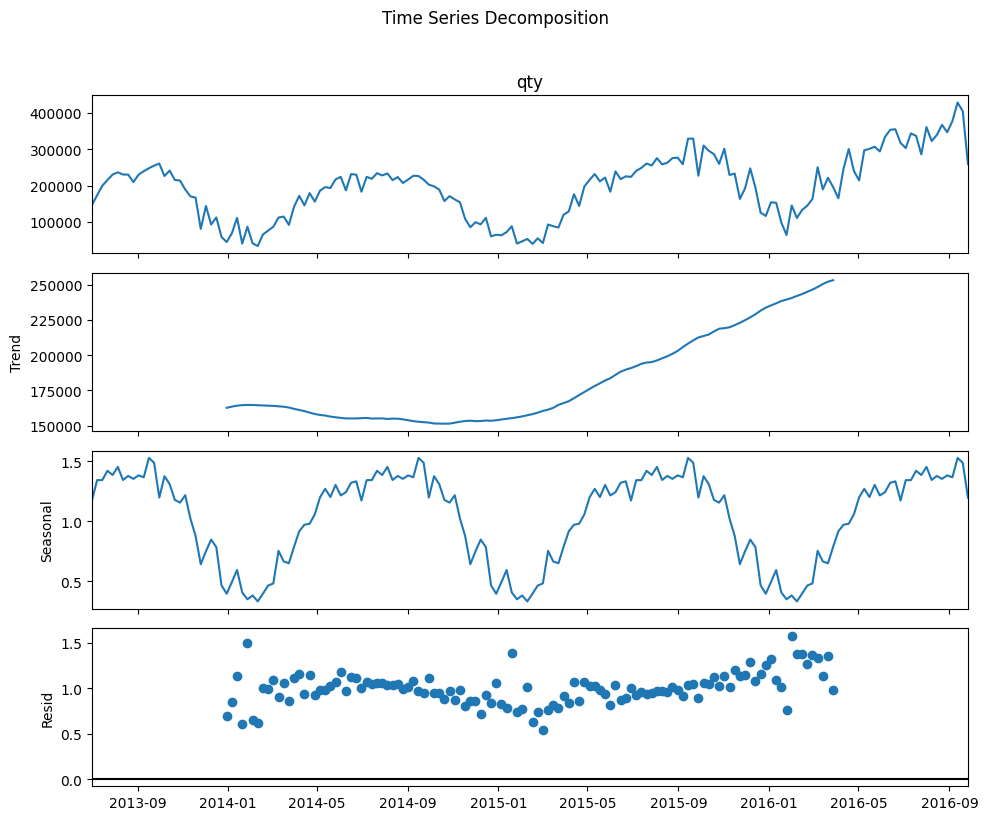

In [26]:
df = df.set_index('monday_of_week')
ts = df['qty']
ts_for_mult = ts.replace(0, 0.01) # Multiplicative models can't handle zero
decomposition = seasonal_decompose(ts, model='multiplicative', period=52)

seasonal_component = decomposition.seasonal

fig = decomposition.plot()
fig.set_size_inches(10, 8)
plt.suptitle('Time Series Decomposition', y=1.02)
plt.tight_layout()
plt.show()

/tmp/ipykernel_96848/1988738852.py:14: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_data, y_data, 'k-', color='grey', markersize=4, alpha=0.5, label='Weekly Data')
/tmp/ipykernel_96848/1988738852.py:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x_smooth, y_smooth, 'k-', color='blue', linewidth=2, label='Smoothed Seasonal Model')


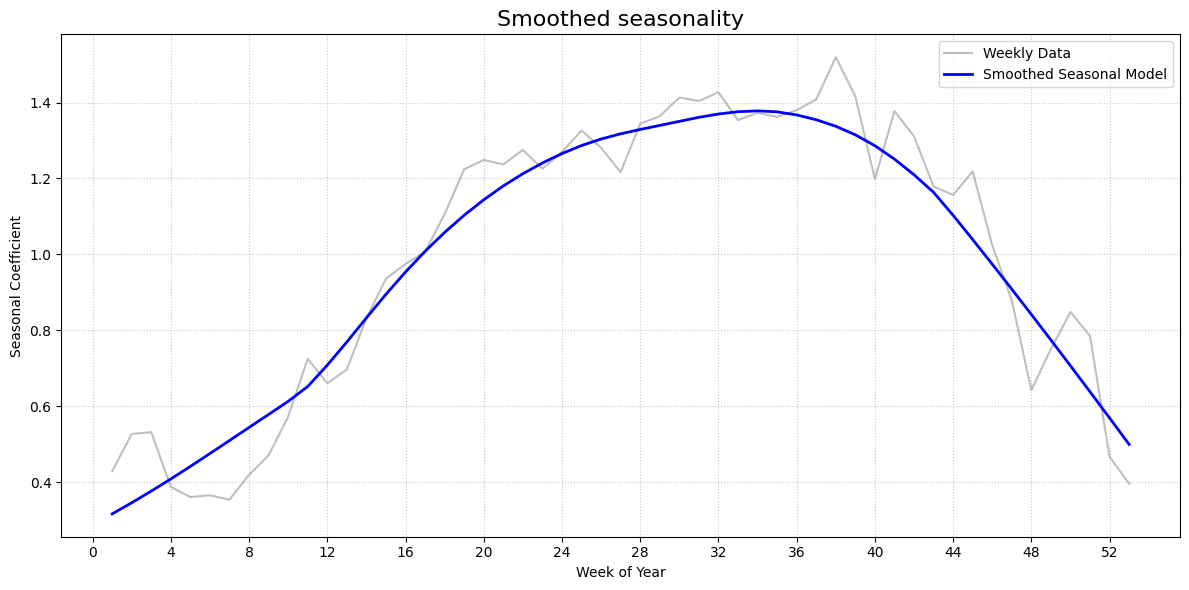

In [27]:
seasonal_df = pd.DataFrame({'Seasonal': seasonal_component})
seasonal_df['WeekOfYear'] = seasonal_df.index.isocalendar().week
typical_seasonality = seasonal_df.groupby('WeekOfYear')['Seasonal'].mean()
y_data = typical_seasonality.values
x_data = typical_seasonality.index.values

smoothed_data = lowess(y_data, x_data, frac=0.4)
x_smooth = smoothed_data[:, 0]
y_smooth = smoothed_data[:, 1]

plt.figure(figsize=(12, 6))

# original seasonal
plt.plot(x_data, y_data, 'k-', color='grey', markersize=4, alpha=0.5, label='Weekly Data')

# smooth LOWESS curve
plt.plot(x_smooth, y_smooth, 'k-', color='blue', linewidth=2, label='Smoothed Seasonal Model')


plt.title('Smoothed seasonality', fontsize=16)
plt.xlabel('Week of Year')
plt.ylabel('Seasonal Coefficient')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.xticks(ticks=range(0, 53, 4))
plt.tight_layout()
plt.show()

The demand is seasonal with peak in summer. This is expected since at colder times, less people ride bikes.